## Construir perfil de densidad de flujo alrededor de las galaxias

In [4]:
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u

def angular_distance(ra1, dec1, ra2, dec2):
    """Compute angular separation between two sets of points in degrees."""
    c1 = SkyCoord(ra1*u.deg, dec1*u.deg, frame='icrs')
    c2 = SkyCoord(ra2*u.deg, dec2*u.deg, frame='icrs')
    return c1.separation(c2).deg

def average_flux_profile(galaxy_ra, galaxy_dec, flux_ra, flux_dec, flux_val, bins_deg):
    """
    For each galaxy, compute average flux in annular bins.
    Then stack profiles across all galaxies.
    """
    n_bins = len(bins_deg) - 1
    profiles = []

    for ra_gal, dec_gal in zip(galaxy_ra, galaxy_dec):
        # Compute angular distances from galaxy to all flux points
        theta = angular_distance(ra_gal, dec_gal, flux_ra, flux_dec)
        
        # Bin the flux values by angular separation
        flux_binned = np.zeros(n_bins)
        counts = np.zeros(n_bins)

        for i in range(n_bins):
            mask = (theta >= bins_deg[i]) & (theta < bins_deg[i+1])
            if np.any(mask):
                flux_binned[i] = np.mean(flux_val[mask])
                counts[i] = np.sum(mask)
            else:
                flux_binned[i] = np.nan  # or set to 0

        profiles.append(flux_binned)

    profiles = np.array(profiles)
    mean_profile = np.nanmean(profiles, axis=0)
    std_profile = np.nanstd(profiles, axis=0) / np.sqrt(len(profiles))

    return mean_profile, std_profile, (bins_deg[:-1] + bins_deg[1:]) / 2  # bin centers


In [5]:
from astropy.io import ascii

gxs = ascii.read('../data/2MRSxWISE_sinBPTAGNs.txt')
flux_map = ascii.read('../data/Auger/flux_a8_lb.dat')
print(flux_map.keys())

# Galaxy coordinates (example)
galaxy_ra = gxs['_RAJ2000']
galaxy_dec = gxs['_DEJ2000']

# Flux map arrays
flux_ra = flux_map['RA']
flux_dec = flux_map['dec']
flux_val = flux_map['Flux[km^-2_sr^-1_yr^-1]']

# Binning (e.g., 0° to 10°, in 1° bins)
bins = np.linspace(0, 10, 11)

mean_flux, err_flux, theta_bins = average_flux_profile(galaxy_ra, galaxy_dec,
                                                        flux_ra, flux_dec,
                                                        flux_val, bins)

# Plot
import matplotlib.pyplot as plt
plt.errorbar(theta_bins, mean_flux, yerr=err_flux, fmt='o')
plt.xlabel('Angular separation [deg]')
plt.ylabel('Mean flux around galaxies')
plt.title('Stacked Flux Profile around Galaxies')
plt.grid()
plt.show()


['dec', 'RA', 'Flux[km^-2_sr^-1_yr^-1]', 'Flux_uncertainty', 'GAL_LONGx1', 'GAL_LATx1']


KeyboardInterrupt: 

### Using CKDTrees

Processing galaxies with cz in range: 1200 - 3600
Processing galaxies with cz in range: 3600 - 5000
Processing galaxies with cz in range: 6000 - 6500
Processing galaxies with cz in range: 6500 - 7000
Processing galaxies with cz in range: 9000 - 9400


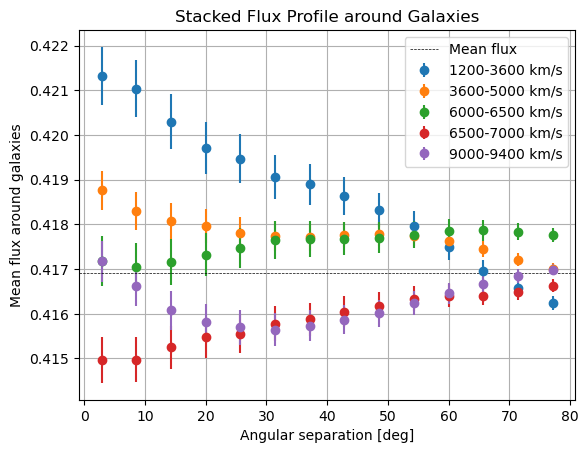

In [15]:
from scipy.spatial import cKDTree

def sph_to_cart(ra_deg, dec_deg):
    """Convert (RA, Dec) in degrees to 3D unit Cartesian coordinates."""
    ra = np.radians(ra_deg)
    dec = np.radians(dec_deg)
    x = np.cos(dec) * np.cos(ra)
    y = np.cos(dec) * np.sin(ra)
    z = np.sin(dec)
    return np.column_stack((x, y, z))

def average_flux_profile_kdtree(galaxy_ra, galaxy_dec, flux_ra, flux_dec, flux_val, bins_deg):
    flux_xyz = sph_to_cart(flux_ra, flux_dec)
    galaxy_xyz = sph_to_cart(galaxy_ra, galaxy_dec)

    tree = cKDTree(flux_xyz)
    
    # Convert angular bins (in deg) to chord distances
    theta_rad = np.radians(bins_deg)
    chord_bins = 2 * np.sin(theta_rad / 2)
    n_bins = len(chord_bins) - 1

    profiles = []

    for xyz in galaxy_xyz:
        # Query all points within the largest chord bin
        idx_all = tree.query_ball_point(xyz, chord_bins[-1])
        if not idx_all:
            profiles.append([np.nan]*n_bins)
            continue

        # Get distances only to these nearby points
        dists = np.linalg.norm(flux_xyz[idx_all] - xyz, axis=1)
        fluxes = flux_val[idx_all]

        # Bin by distance
        flux_binned = np.zeros(n_bins)
        for i in range(n_bins):
            mask = (dists >= chord_bins[i]) & (dists < chord_bins[i+1])
            if np.any(mask):
                flux_binned[i] = np.mean(fluxes[mask])
            else:
                flux_binned[i] = np.nan

        profiles.append(flux_binned)

    profiles = np.array(profiles)
    mean_profile = np.nanmean(profiles, axis=0)
    std_profile = np.nanstd(profiles, axis=0) / np.sqrt(np.sum(~np.isnan(profiles), axis=0))

    return mean_profile, std_profile, (bins_deg[:-1] + bins_deg[1:]) / 2

from astropy.io import ascii
import matplotlib.pyplot as plt

gxs_total = ascii.read('../data/2MRSxWISE_sinBPTAGNs.txt')
flux_map = ascii.read('../data/Auger/flux_a8_lb.dat')

cz_mins = [1200,3600,6000,6500,9000]
cz_max = [3600,5000,6500,7000,9400]
for cz_min, cz_max in zip(cz_mins, cz_max):

    print('Processing galaxies with cz in range:', cz_min, '-', cz_max)

    gxs = gxs_total[(gxs_total['cz']>cz_min)&(gxs_total['cz']<cz_max)]  # Filter galaxies by cz
    # Galaxy coordinates (example)
    galaxy_ra = gxs['_RAJ2000']
    galaxy_dec = gxs['_DEJ2000']

    # Flux map arrays
    flux_ra = flux_map['RA']
    flux_dec = flux_map['dec']
    flux_val = flux_map['Flux[km^-2_sr^-1_yr^-1]']

    # Binning (e.g., 0° to 10°, in 1° bins)
    bins = np.linspace(0, 80, 15)

    mean_flux, err_flux, theta_bins = average_flux_profile_kdtree(galaxy_ra, galaxy_dec,
                                                            flux_ra, flux_dec,
                                                            flux_val, bins)

    # Plot
    plt.errorbar(theta_bins, mean_flux, yerr=err_flux, fmt='o', label=f'{cz_min}-{cz_max} km/s')

plt.axhline(np.mean(flux_map['Flux[km^-2_sr^-1_yr^-1]']), color='black', linestyle='--', linewidth=0.5, label='Mean flux')
plt.xlabel('Angular separation [deg]')
plt.ylabel('Mean flux around galaxies')
plt.legend()
plt.title('Stacked Flux Profile around Galaxies')
plt.grid()
plt.show()


### K bins

Processing galaxies with K in range: -26 - -24
Processing galaxies with K in range: -24 - -23
Processing galaxies with K in range: -23 - -22


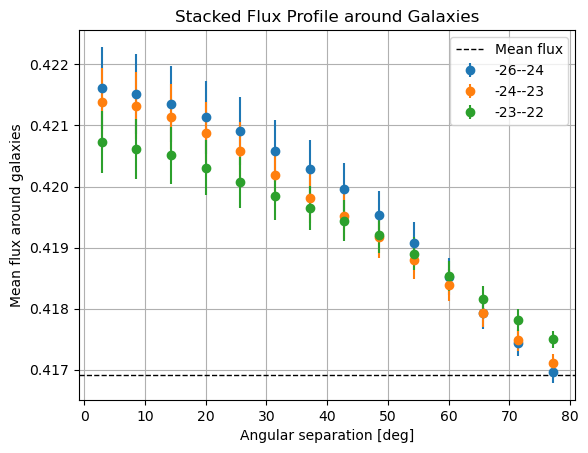

In [6]:
from scipy.spatial import cKDTree

def sph_to_cart(ra_deg, dec_deg):
    """Convert (RA, Dec) in degrees to 3D unit Cartesian coordinates."""
    ra = np.radians(ra_deg)
    dec = np.radians(dec_deg)
    x = np.cos(dec) * np.cos(ra)
    y = np.cos(dec) * np.sin(ra)
    z = np.sin(dec)
    return np.column_stack((x, y, z))

def average_flux_profile_kdtree(galaxy_ra, galaxy_dec, flux_ra, flux_dec, flux_val, bins_deg):
    flux_xyz = sph_to_cart(flux_ra, flux_dec)
    galaxy_xyz = sph_to_cart(galaxy_ra, galaxy_dec)

    tree = cKDTree(flux_xyz)
    
    # Convert angular bins (in deg) to chord distances
    theta_rad = np.radians(bins_deg)
    chord_bins = 2 * np.sin(theta_rad / 2)
    n_bins = len(chord_bins) - 1

    profiles = []

    for xyz in galaxy_xyz:
        # Query all points within the largest chord bin
        idx_all = tree.query_ball_point(xyz, chord_bins[-1])
        if not idx_all:
            profiles.append([np.nan]*n_bins)
            continue

        # Get distances only to these nearby points
        dists = np.linalg.norm(flux_xyz[idx_all] - xyz, axis=1)
        fluxes = flux_val[idx_all]

        # Bin by distance
        flux_binned = np.zeros(n_bins)
        for i in range(n_bins):
            mask = (dists >= chord_bins[i]) & (dists < chord_bins[i+1])
            if np.any(mask):
                flux_binned[i] = np.mean(fluxes[mask])
            else:
                flux_binned[i] = np.nan

        profiles.append(flux_binned)

    profiles = np.array(profiles)
    mean_profile = np.nanmean(profiles, axis=0)
    std_profile = np.nanstd(profiles, axis=0) / np.sqrt(np.sum(~np.isnan(profiles), axis=0))

    return mean_profile, std_profile, (bins_deg[:-1] + bins_deg[1:]) / 2

from astropy.io import ascii
import matplotlib.pyplot as plt

gxs_total = ascii.read('../data/VLS_ang5_cz_700control_def.txt')
gxs_total = gxs_total[gxs_total['_DEJ2000'] < 45.]  # Filter by declination
gxs_total = gxs_total[(gxs_total['cz']>1200)]
flux_map = ascii.read('../data/Auger/flux_a8_lb.dat')

K_mins = [-26,-24,-23]
K_max = [-24,-23,-22]
for K_min, K_max in zip(K_mins, K_max):

    print('Processing galaxies with K in range:', K_min, '-', K_max)

    gxs = gxs_total[(gxs_total['K_abs']>K_min)&(gxs_total['K_abs']<K_max)]  # Filter galaxies by K
    # Galaxy coordinates (example)
    galaxy_ra = gxs['_RAJ2000']
    galaxy_dec = gxs['_DEJ2000']

    # Flux map arrays
    flux_ra = flux_map['RA']
    flux_dec = flux_map['dec']
    flux_val = flux_map['Flux[km^-2_sr^-1_yr^-1]']

    # Binning (e.g., 0° to 10°, in 1° bins)
    bins = np.linspace(0, 80, 15)

    mean_flux, err_flux, theta_bins = average_flux_profile_kdtree(galaxy_ra, galaxy_dec,
                                                            flux_ra, flux_dec,
                                                            flux_val, bins)

    # Plot
    plt.errorbar(theta_bins, mean_flux, yerr=err_flux, fmt='o', label=f'{K_min}-{K_max}')

plt.axhline(np.mean(flux_map['Flux[km^-2_sr^-1_yr^-1]']), color='black', linestyle='--', linewidth=1, label='Mean flux')
plt.xlabel('Angular separation [deg]')
plt.ylabel('Mean flux around galaxies')
plt.legend()
plt.title('Stacked Flux Profile around Galaxies')
plt.grid()
plt.show()


## With skymaps

Processing galaxies with cz in range: 1200 - 3600
Processing galaxies with cz in range: 3600 - 5000
Processing galaxies with cz in range: 5000 - 6000
Processing galaxies with cz in range: 6000 - 6500
Processing galaxies with cz in range: 6500 - 7500
Processing galaxies with cz in range: 7500 - 8000
Processing galaxies with cz in range: 8000 - 8500
Processing galaxies with cz in range: 8500 - 9000
Processing galaxies with cz in range: 9000 - 9400


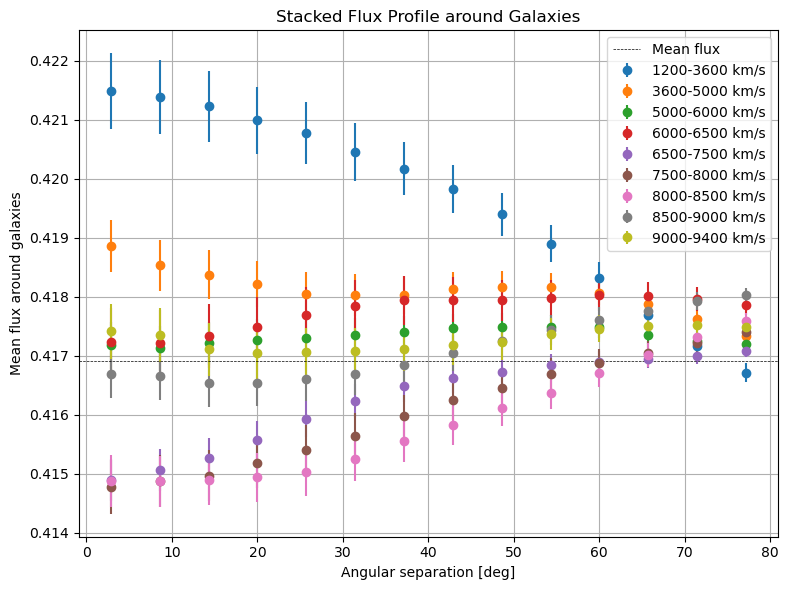

In [4]:
from astropy.io import ascii
import matplotlib.pyplot as plt
import numpy as np

def sph_to_cart(ra_deg, dec_deg):
    ra = np.radians(ra_deg)
    dec = np.radians(dec_deg)
    x = np.cos(dec) * np.cos(ra)
    y = np.cos(dec) * np.sin(ra)
    z = np.sin(dec)
    return np.column_stack((x, y, z))

from scipy.spatial import cKDTree
def average_flux_profile_kdtree(galaxy_ra, galaxy_dec, flux_ra, flux_dec, flux_val, bins_deg):
    flux_xyz = sph_to_cart(flux_ra, flux_dec)
    galaxy_xyz = sph_to_cart(galaxy_ra, galaxy_dec)

    tree = cKDTree(flux_xyz)
    
    theta_rad = np.radians(bins_deg)
    chord_bins = 2 * np.sin(theta_rad / 2)
    n_bins = len(chord_bins) - 1

    profiles = []
    for xyz in galaxy_xyz:
        idx_all = tree.query_ball_point(xyz, chord_bins[-1])
        if not idx_all:
            profiles.append([np.nan]*n_bins)
            continue

        dists = np.linalg.norm(flux_xyz[idx_all] - xyz, axis=1)
        fluxes = flux_val[idx_all]

        flux_binned = np.zeros(n_bins)
        for i in range(n_bins):
            mask = (dists >= chord_bins[i]) & (dists < chord_bins[i+1])
            flux_binned[i] = np.mean(fluxes[mask]) if np.any(mask) else np.nan

        profiles.append(flux_binned)

    profiles = np.array(profiles)
    mean_profile = np.nanmean(profiles, axis=0)
    std_profile = np.nanstd(profiles, axis=0) / np.sqrt(np.sum(~np.isnan(profiles), axis=0))

    return mean_profile, std_profile, (bins_deg[:-1] + bins_deg[1:]) / 2

# === Load data ===
gxs_total = ascii.read('../data/2MRSxWISE_sinBPTAGNs.txt')
gxs_total = gxs_total[gxs_total['_DEJ2000'] < 45.] 
flux_map = ascii.read('../data/Auger/flux_a8_lb.dat')

cz_mins = [1200,3600,5000,6000,6500,7500,8000,8500,9000]
cz_maxs = [3600,5000,6000,6500,7500,8000,8500,9000,9400]

mean_flux = []
err_flux = []
for cz_min, cz_max in zip(cz_mins, cz_maxs):

    print('Processing galaxies with cz in range:', cz_min, '-', cz_max)

    gxs = gxs_total[(gxs_total['cz']>cz_min) & (gxs_total['cz']<cz_max)]
    galaxy_ra = gxs['_RAJ2000']
    galaxy_dec = gxs['_DEJ2000']

    flux_ra = flux_map['RA']
    flux_dec = flux_map['dec']
    flux_val = flux_map['Flux[km^-2_sr^-1_yr^-1]']

    bins = np.linspace(0, 80, 15)

    _mean_flux, _err_flux, theta_bins = average_flux_profile_kdtree(
        galaxy_ra, galaxy_dec, flux_ra, flux_dec, flux_val, bins)
    mean_flux.append(_mean_flux)
    err_flux.append(_err_flux)

    # --- Add sky map ---
    fig_sky, ax_sky = plt.subplots(subplot_kw={'projection': 'hammer'}, figsize=(10, 5))

    # RA flip for hammer
    ra_flux = np.radians((flux_ra + 180) % 360 - 180)
    dec_flux = np.radians(flux_dec)
    flux_norm = (flux_val - np.min(flux_val)) / (np.max(flux_val) - np.min(flux_val))

    # Plot flux map
    sc = ax_sky.scatter(ra_flux, dec_flux, c=flux_val, cmap='coolwarm', s=5, alpha=0.8)

    # Plot galaxies
    ra_gxs = np.radians((galaxy_ra + 180) % 360 - 180)
    dec_gxs = np.radians(galaxy_dec)
    ax_sky.scatter(ra_gxs, dec_gxs, color='black', s=8, label='Galaxies')

    # Add colorbar
    cbar = fig_sky.colorbar(sc, ax=ax_sky, orientation='horizontal', pad=0.07, shrink=0.8)
    cbar.set_label('Flux [km$^{-2}$ sr$^{-1}$ yr$^{-1}$]')

    # Add rest of layout
    ax_sky.set_title(f'Sky map: {cz_min}-{cz_max} km/s')
    ax_sky.grid(True)
    ax_sky.legend(loc='lower left')

    plt.figure(fig_sky.number)
    plt.tight_layout()
    plt.savefig('../plots/flux_vs_theta_sky_map_{}_{}.png'.format(cz_min, cz_max), dpi=300)
    plt.close(fig_sky)


# --- Final profile plot ---
fig_profile, ax_profile = plt.subplots(figsize=(8, 6))
for i in range(len(mean_flux)):
    cz_min = cz_mins[i]
    cz_max = cz_maxs[i]
    ax_profile.errorbar(theta_bins, mean_flux[i], yerr=err_flux[i], fmt='o', label=f'{cz_min}-{cz_max} km/s')
ax_profile.axhline(np.mean(flux_val), color='black', linestyle='--', linewidth=0.5, label='Mean flux')
ax_profile.set_xlabel('Angular separation [deg]')
ax_profile.set_ylabel('Mean flux around galaxies')
ax_profile.set_title('Stacked Flux Profile around Galaxies')
ax_profile.grid()
ax_profile.legend()
fig_profile.tight_layout()
plt.show()


### Taking into account flux uncertainties

['dec', 'RA', 'Flux[km^-2_sr^-1_yr^-1]', 'Flux_uncertainty', 'GAL_LONGx1', 'GAL_LATx1']
Processing galaxies with cz in range: 1200 - 3600
Processing galaxies with cz in range: 3600 - 5000
Processing galaxies with cz in range: 5000 - 6000
Processing galaxies with cz in range: 6000 - 6500
Processing galaxies with cz in range: 6500 - 7500
Processing galaxies with cz in range: 7500 - 8000
Processing galaxies with cz in range: 8000 - 8500
Processing galaxies with cz in range: 8500 - 9000
Processing galaxies with cz in range: 9000 - 9400


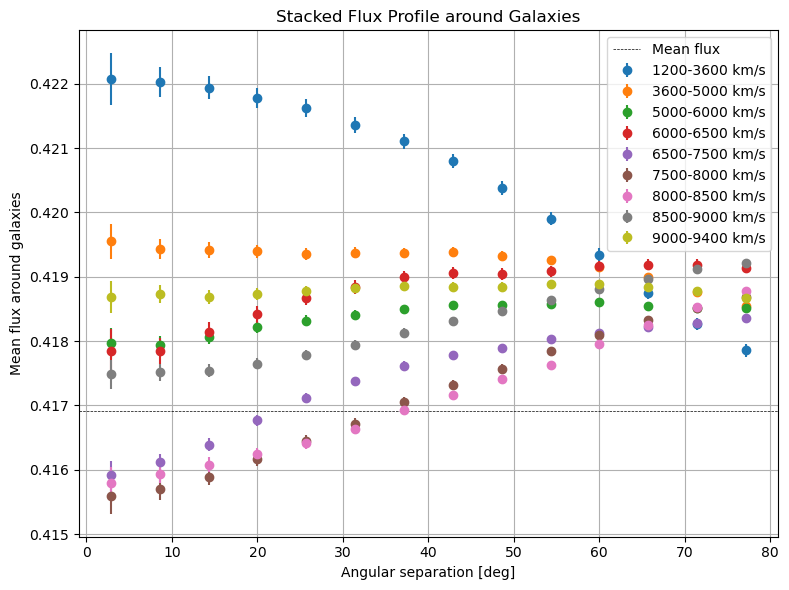

In [12]:
from astropy.io import ascii
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import cKDTree

def sph_to_cart(ra_deg, dec_deg):
    ra = np.radians(ra_deg)
    dec = np.radians(dec_deg)
    x = np.cos(dec) * np.cos(ra)
    y = np.cos(dec) * np.sin(ra)
    z = np.sin(dec)
    return np.column_stack((x, y, z))

def average_flux_profile_kdtree(galaxy_ra, galaxy_dec, flux_ra, flux_dec, flux_val, flux_err, bins_deg):
    flux_xyz = sph_to_cart(flux_ra, flux_dec)
    galaxy_xyz = sph_to_cart(galaxy_ra, galaxy_dec)

    tree = cKDTree(flux_xyz)
    theta_rad = np.radians(bins_deg)
    chord_bins = 2 * np.sin(theta_rad / 2)
    n_bins = len(chord_bins) - 1

    profiles = []
    weights_total = []
    for xyz in galaxy_xyz:
        idx_all = tree.query_ball_point(xyz, chord_bins[-1])
        if not idx_all:
            profiles.append([np.nan]*n_bins)
            weights_total.append([0]*n_bins)
            continue

        dists = np.linalg.norm(flux_xyz[idx_all] - xyz, axis=1)
        fluxes = flux_val[idx_all]
        errors = flux_err[idx_all]

        flux_binned = np.zeros(n_bins)
        weights = np.zeros(n_bins)

        for i in range(n_bins):
            mask = (dists >= chord_bins[i]) & (dists < chord_bins[i+1])
            if np.any(mask):
                w = 1. / errors[mask]**2
                flux_binned[i] = np.sum(fluxes[mask] * w) / np.sum(w)
                weights[i] = np.sum(w)
            else:
                flux_binned[i] = np.nan
                weights[i] = 0

        profiles.append(flux_binned)
        weights_total.append(weights)

    profiles = np.array(profiles)
    weights_total = np.array(weights_total)

    # Weighted mean over all galaxies
    weighted_sums = np.nansum(profiles * weights_total, axis=0)
    total_weights = np.nansum(weights_total, axis=0)

    mean_profile = weighted_sums / total_weights
    std_profile = 1 / np.sqrt(total_weights)  # standard error of weighted mean

    return mean_profile, std_profile, (bins_deg[:-1] + bins_deg[1:]) / 2


# === Load data ===
gxs_total = ascii.read('../data/2MRSxWISE_sinBPTAGNs.txt')
gxs_total = gxs_total[gxs_total['_DEJ2000'] < 45.] 
flux_map = ascii.read('../data/Auger/flux_a8_lb.dat')
print(flux_map.keys())

cz_mins = [1200,3600,5000,6000,6500,7500,8000,8500,9000]
cz_maxs = [3600,5000,6000,6500,7500,8000,8500,9000,9400]

mean_flux = []
err_flux = []
for cz_min, cz_max in zip(cz_mins, cz_maxs):

    print('Processing galaxies with cz in range:', cz_min, '-', cz_max)

    gxs = gxs_total[(gxs_total['cz']>cz_min) & (gxs_total['cz']<cz_max)]
    galaxy_ra = gxs['_RAJ2000']
    galaxy_dec = gxs['_DEJ2000']

    flux_ra = flux_map['RA']
    flux_dec = flux_map['dec']
    flux_val = flux_map['Flux[km^-2_sr^-1_yr^-1]']
    flux_err = np.sqrt(flux_map['Flux_uncertainty'])
    
    bins = np.linspace(0, 80, 15)

    _mean_flux, _err_flux, theta_bins = average_flux_profile_kdtree(
        galaxy_ra, galaxy_dec, flux_ra, flux_dec, flux_val, flux_err, bins)
    mean_flux.append(_mean_flux)
    err_flux.append(_err_flux)

    # --- Add sky map ---
    fig_sky, ax_sky = plt.subplots(subplot_kw={'projection': 'hammer'}, figsize=(10, 5))

    # RA flip for hammer
    ra_flux = np.radians((flux_ra + 180) % 360 - 180)
    dec_flux = np.radians(flux_dec)
    flux_norm = (flux_val - np.min(flux_val)) / (np.max(flux_val) - np.min(flux_val))

    # Plot flux map
    sc = ax_sky.scatter(ra_flux, dec_flux, c=flux_val, cmap='coolwarm', s=5, alpha=0.8)

    # Plot galaxies
    ra_gxs = np.radians((galaxy_ra + 180) % 360 - 180)
    dec_gxs = np.radians(galaxy_dec)
    ax_sky.scatter(ra_gxs, dec_gxs, color='black', s=8, label='Galaxies')

    # Add colorbar
    cbar = fig_sky.colorbar(sc, ax=ax_sky, orientation='horizontal', pad=0.07, shrink=0.8)
    cbar.set_label('Flux [km$^{-2}$ sr$^{-1}$ yr$^{-1}$]')

    # Add rest of layout
    ax_sky.set_title(f'Sky map: {cz_min}-{cz_max} km/s')
    ax_sky.grid(True)
    ax_sky.legend(loc='lower left')

    plt.figure(fig_sky.number)
    plt.tight_layout()
    plt.savefig('../plots/flux_vs_theta_sky_map_{}_{}.png'.format(cz_min, cz_max), dpi=300)
    plt.close(fig_sky)


# --- Final profile plot ---
fig_profile, ax_profile = plt.subplots(figsize=(8, 6))
for i in range(len(mean_flux)):
    cz_min = cz_mins[i]
    cz_max = cz_maxs[i]
    ax_profile.errorbar(theta_bins, mean_flux[i], yerr=err_flux[i], fmt='o', label=f'{cz_min}-{cz_max} km/s')
ax_profile.axhline(np.mean(flux_val), color='black', linestyle='--', linewidth=0.5, label='Mean flux')
ax_profile.set_xlabel('Angular separation [deg]')
ax_profile.set_ylabel('Mean flux around galaxies')
ax_profile.set_title('Stacked Flux Profile around Galaxies')
ax_profile.grid()
ax_profile.legend()
fig_profile.tight_layout()
plt.show()


#### High and low deflection zones, poisson uncertainties (no flux uncertainty)

Processing galaxies in high deflection zone
Processing galaxies in low deflection zone
Processing galaxies in no deflection zone


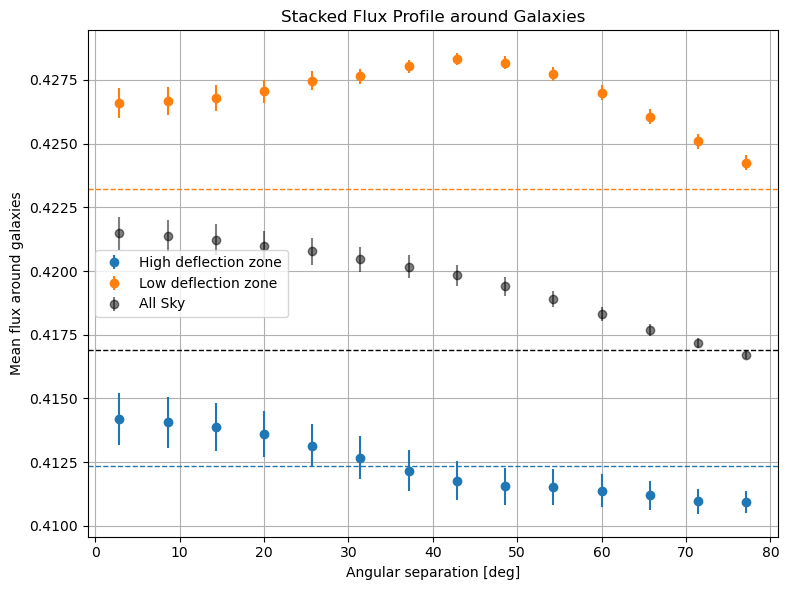

In [9]:
from astropy.io import ascii
import matplotlib.pyplot as plt
import numpy as np
from get_masks import get_deflection_mask

def sph_to_cart(ra_deg, dec_deg):
    ra = np.radians(ra_deg)
    dec = np.radians(dec_deg)
    x = np.cos(dec) * np.cos(ra)
    y = np.cos(dec) * np.sin(ra)
    z = np.sin(dec)
    return np.column_stack((x, y, z))

from scipy.spatial import cKDTree
def average_flux_profile_kdtree(galaxy_ra, galaxy_dec, flux_ra, flux_dec, flux_val, bins_deg):
    flux_xyz = sph_to_cart(flux_ra, flux_dec)
    galaxy_xyz = sph_to_cart(galaxy_ra, galaxy_dec)

    tree = cKDTree(flux_xyz)
    
    theta_rad = np.radians(bins_deg)
    chord_bins = 2 * np.sin(theta_rad / 2)
    n_bins = len(chord_bins) - 1

    profiles = []
    for xyz in galaxy_xyz:
        idx_all = tree.query_ball_point(xyz, chord_bins[-1])
        if not idx_all:
            profiles.append([np.nan]*n_bins)
            continue

        dists = np.linalg.norm(flux_xyz[idx_all] - xyz, axis=1)
        fluxes = flux_val[idx_all]

        flux_binned = np.zeros(n_bins)
        for i in range(n_bins):
            mask = (dists >= chord_bins[i]) & (dists < chord_bins[i+1])
            flux_binned[i] = np.mean(fluxes[mask]) if np.any(mask) else np.nan

        profiles.append(flux_binned)

    profiles = np.array(profiles)
    mean_profile = np.nanmean(profiles, axis=0)
    std_profile = np.nanstd(profiles, axis=0) / np.sqrt(np.sum(~np.isnan(profiles), axis=0))

    return mean_profile, std_profile, (bins_deg[:-1] + bins_deg[1:]) / 2

# === Load data ===
cz_min = 1200
cz_max = 3600
deflection_file = '../data/JF12_GMFdeflection_Z1_E10EeV.csv'
gxs_total = ascii.read('../data/2MRSxWISE_sinBPTAGNs.txt')
gxs_total = gxs_total[gxs_total['_DEJ2000'] < 45.]
gxs_total = gxs_total[(gxs_total['cz']>cz_min) & (gxs_total['cz']<cz_max)]
flux_map_total = ascii.read('../data/Auger/flux_a8_lb.dat')

# === Process galaxies in deflection zones ===
mean_flux = []
err_flux = []
mean_flux_val = []
for deflection in ['high', 'low', 'no']:

    print('Processing galaxies in', deflection, 'deflection zone')

    if deflection != 'no':
        deflection_mask_gxs = get_deflection_mask(deflection_file, gxs_total['_RAJ2000'], gxs_total['_DEJ2000'], deflection)
        deflection_mask_flux = get_deflection_mask(deflection_file, flux_map_total['RA'], flux_map_total['dec'], deflection)
        gxs = gxs_total[deflection_mask_gxs]
        flux_map = flux_map_total[deflection_mask_flux]
    else:
        gxs = gxs_total
        flux_map = flux_map_total

    galaxy_ra = gxs['_RAJ2000']
    galaxy_dec = gxs['_DEJ2000']

    flux_ra = flux_map['RA']
    flux_dec = flux_map['dec']
    flux_val = flux_map['Flux[km^-2_sr^-1_yr^-1]']
    mean_flux_val.append( np.mean(flux_val) )

    bins = np.linspace(0, 80, 15)

    _mean_flux, _err_flux, theta_bins = average_flux_profile_kdtree(
        galaxy_ra, galaxy_dec, flux_ra, flux_dec, flux_val, bins)
    mean_flux.append(_mean_flux)
    err_flux.append(_err_flux)

    # --- Add sky map ---
    fig_sky, ax_sky = plt.subplots(subplot_kw={'projection': 'hammer'}, figsize=(10, 5))

    # RA flip for hammer
    ra_flux = np.radians((flux_ra + 180) % 360 - 180)
    dec_flux = np.radians(flux_dec)
    flux_norm = (flux_val - np.min(flux_val)) / (np.max(flux_val) - np.min(flux_val))

    # Plot flux map
    sc = ax_sky.scatter(ra_flux, dec_flux, c=flux_val, cmap='coolwarm', s=5, alpha=0.8)

    # Plot galaxies
    ra_gxs = np.radians((galaxy_ra + 180) % 360 - 180)
    dec_gxs = np.radians(galaxy_dec)
    ax_sky.scatter(ra_gxs, dec_gxs, color='black', s=8, label='Galaxies')

    # Add colorbar
    cbar = fig_sky.colorbar(sc, ax=ax_sky, orientation='horizontal', pad=0.07, shrink=0.8)
    cbar.set_label('Flux [km$^{-2}$ sr$^{-1}$ yr$^{-1}$]')

    # Add rest of layout
    ax_sky.set_title(f'Sky map: {cz_min}-{cz_max} km/s')
    ax_sky.grid(True)
    ax_sky.legend(loc='lower left')

    plt.figure(fig_sky.number)
    plt.tight_layout()
    plt.savefig('../plots/flux_vs_theta_sky_map_{}-deflection.png'.format(deflection), dpi=300)
    plt.close(fig_sky)


# --- Final profile plot ---
fig_profile, ax_profile = plt.subplots(figsize=(8, 6))
ax_profile.errorbar(theta_bins, mean_flux[0], yerr=err_flux[0], fmt='o', label=f'High deflection zone')
ax_profile.errorbar(theta_bins, mean_flux[1], yerr=err_flux[1], fmt='o', label=f'Low deflection zone')
ax_profile.errorbar(theta_bins, mean_flux[2], yerr=err_flux[2], fmt='o', c='k', alpha=.5, label=f'All Sky')

ax_profile.axhline(mean_flux_val[0], color='black', linestyle='--', linewidth=1, c='C0')
ax_profile.axhline(mean_flux_val[1], color='black', linestyle='--', linewidth=1, c='C1')
ax_profile.axhline(mean_flux_val[2], color='black', linestyle='--', linewidth=1, c='k')

ax_profile.set_xlabel('Angular separation [deg]')
ax_profile.set_ylabel('Mean flux around galaxies')
ax_profile.set_title('Stacked Flux Profile around Galaxies')
ax_profile.grid()
ax_profile.legend()
fig_profile.tight_layout()
plt.show()


### Controlled sample, check flux for gclass 2, 3 and AGNs

Processing galaxies class 2
314
Processing galaxies class 3
312
Processing galaxies class no
626
Processing galaxies class agn
458


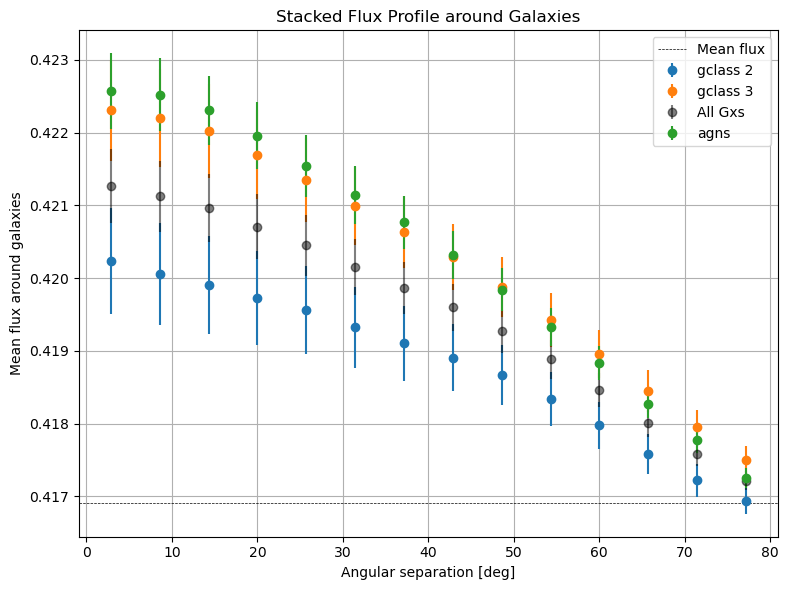

In [ ]:
from astropy.io import ascii
import matplotlib.pyplot as plt
import numpy as np
from get_masks import get_deflection_mask

def sph_to_cart(ra_deg, dec_deg):
    ra = np.radians(ra_deg)
    dec = np.radians(dec_deg)
    x = np.cos(dec) * np.cos(ra)
    y = np.cos(dec) * np.sin(ra)
    z = np.sin(dec)
    return np.column_stack((x, y, z))

from scipy.spatial import cKDTree
def average_flux_profile_kdtree(galaxy_ra, galaxy_dec, flux_ra, flux_dec, flux_val, bins_deg):
    flux_xyz = sph_to_cart(flux_ra, flux_dec)
    galaxy_xyz = sph_to_cart(galaxy_ra, galaxy_dec)

    tree = cKDTree(flux_xyz)
    
    theta_rad = np.radians(bins_deg)
    chord_bins = 2 * np.sin(theta_rad / 2)
    n_bins = len(chord_bins) - 1

    profiles = []
    for xyz in galaxy_xyz:
        idx_all = tree.query_ball_point(xyz, chord_bins[-1])
        if not idx_all:
            profiles.append([np.nan]*n_bins)
            continue

        dists = np.linalg.norm(flux_xyz[idx_all] - xyz, axis=1)
        fluxes = flux_val[idx_all]

        flux_binned = np.zeros(n_bins)
        for i in range(n_bins):
            mask = (dists >= chord_bins[i]) & (dists < chord_bins[i+1])
            flux_binned[i] = np.mean(fluxes[mask]) if np.any(mask) else np.nan

        profiles.append(flux_binned)

    profiles = np.array(profiles)
    mean_profile = np.nanmean(profiles, axis=0)
    std_profile = np.nanstd(profiles, axis=0) / np.sqrt(np.sum(~np.isnan(profiles), axis=0))

    return mean_profile, std_profile, (bins_deg[:-1] + bins_deg[1:]) / 2

# === Load data ===
gxs_file = '../data/2MRSxWISE_VLS_d1d5_sinAGNWISEniBPT_control_SF_passive_cz_Kabs_ang5_cz1000.txt'
agn_file = '../data/VLS_WISEorBPT_AGNs_def_control.txt' # ANGs controladas en K

cz_min = 1200
cz_max = 3600
gxs_total = ascii.read(gxs_file)
gxs_total = gxs_total[gxs_total['_DEJ2000'] < 45.]
gxs_total = gxs_total[(gxs_total['cz']>cz_min) & (gxs_total['cz']<cz_max)]
gxs_total = gxs_total[(gxs_total['K_abs'] > -24.)&(gxs_total['K_abs']<-22.5)]  # Filter by K-band absolute magnitude
flux_map_total = ascii.read('../data/Auger/flux_a8_lb.dat')

# === Process different class galaxies ===
mean_flux = []
err_flux = []
for gclass in [2, 3, 'no', 'agn']:

    print('Processing galaxies class', gclass)

    if gclass in [2, 3]:
        gxs = gxs_total[gxs_total['class']==gclass]  # Filter galaxies by class
    elif gclass=='no':
        gxs = gxs_total
    elif gclass == 'agn':
        gxs_total = ascii.read(agn_file)
        gxs_total = gxs_total[gxs_total['_DEJ2000'] < 45.]
        gxs_total = gxs_total[(gxs_total['cz']>cz_min) & (gxs_total['cz']<cz_max)]
        gxs = gxs_total
    print(len(gxs))

    flux_map = flux_map_total

    galaxy_ra = gxs['_RAJ2000']
    galaxy_dec = gxs['_DEJ2000']

    flux_ra = flux_map['RA']
    flux_dec = flux_map['dec']
    flux_val = flux_map['Flux[km^-2_sr^-1_yr^-1]']

    bins = np.linspace(0, 80, 15)

    _mean_flux, _err_flux, theta_bins = average_flux_profile_kdtree(
        galaxy_ra, galaxy_dec, flux_ra, flux_dec, flux_val, bins)
    mean_flux.append(_mean_flux)
    err_flux.append(_err_flux)

    # --- Add sky map ---
    fig_sky, ax_sky = plt.subplots(subplot_kw={'projection': 'hammer'}, figsize=(10, 5))

    # RA flip for hammer
    ra_flux = np.radians((flux_ra + 180) % 360 - 180)
    dec_flux = np.radians(flux_dec)
    flux_norm = (flux_val - np.min(flux_val)) / (np.max(flux_val) - np.min(flux_val))

    # Plot flux map
    sc = ax_sky.scatter(ra_flux, dec_flux, c=flux_val, cmap='coolwarm', s=5, alpha=0.8)

    # Plot galaxies
    ra_gxs = np.radians((galaxy_ra + 180) % 360 - 180)
    dec_gxs = np.radians(galaxy_dec)
    ax_sky.scatter(ra_gxs, dec_gxs, color='black', s=8, label='Galaxies')

    # Add colorbar
    cbar = fig_sky.colorbar(sc, ax=ax_sky, orientation='horizontal', pad=0.07, shrink=0.8)
    cbar.set_label('Flux [km$^{-2}$ sr$^{-1}$ yr$^{-1}$]')

    # Add rest of layout
    ax_sky.set_title(f'Sky map: {cz_min}-{cz_max} km/s')
    ax_sky.grid(True)
    ax_sky.legend(loc='lower left')

    plt.figure(fig_sky.number)
    plt.tight_layout()
    plt.savefig('../plots/flux_vs_theta_sky_map_gclass{}.png'.format(gclass), dpi=300)
    plt.close(fig_sky)


# --- Final profile plot ---
fig_profile, ax_profile = plt.subplots(figsize=(8, 6))
ax_profile.errorbar(theta_bins, mean_flux[0], yerr=err_flux[0], fmt='o', label=f'gclass 2')
ax_profile.errorbar(theta_bins, mean_flux[1], yerr=err_flux[1], fmt='o', label=f'gclass 3')
ax_profile.errorbar(theta_bins, mean_flux[2], yerr=err_flux[2], fmt='o', c='k', alpha=.5, label=f'All Gxs')
ax_profile.errorbar(theta_bins, mean_flux[3], yerr=err_flux[3], fmt='o', label=f'agns')

ax_profile.axhline(np.mean(flux_map_total['Flux[km^-2_sr^-1_yr^-1]']), color='black', linestyle='--', linewidth=0.5, label='Mean flux')
ax_profile.set_xlabel('Angular separation [deg]')
ax_profile.set_ylabel('Mean flux around galaxies')
ax_profile.set_title('Stacked Flux Profile around Galaxies')
ax_profile.grid()
ax_profile.legend()
fig_profile.tight_layout()
plt.show()


### Weigh by deflection

##### First check skymap

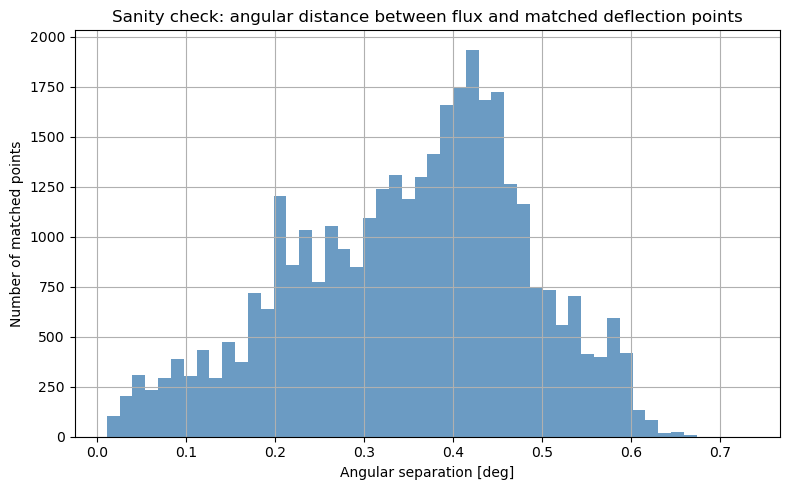

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.coordinates import SkyCoord
import astropy.units as u
from scipy.spatial import cKDTree

# === 1. Load flux and deflection maps ===
flux_map = ascii.read('../data/Auger/flux_a8_lb.dat')
defl_map = ascii.read('../data/JF12_GMFdeflection_Z1_E10EeV.csv')

# === 2. Convert deflection map from Galactic (l, b) to Equatorial (RA, Dec) ===
l = defl_map['l'] * u.deg
b = defl_map['b'] * u.deg
gal_coords = SkyCoord(l=l, b=b, frame='galactic')
eq_coords = gal_coords.icrs  # converts to (RA, Dec)

defl_ra = eq_coords.ra.deg
defl_dec = eq_coords.dec.deg

# === 3. Convert all coordinates to Cartesian ===
def sph_to_cart(ra_deg, dec_deg):
    ra = np.radians(ra_deg)
    dec = np.radians(dec_deg)
    x = np.cos(dec) * np.cos(ra)
    y = np.cos(dec) * np.sin(ra)
    z = np.sin(dec)
    return np.column_stack((x, y, z))

flux_xyz = sph_to_cart(flux_map['RA'], flux_map['dec'])
defl_xyz = sph_to_cart(defl_ra, defl_dec)

# === 4. Match flux points to nearest deflection points ===
tree_defl = cKDTree(defl_xyz)
dists, idx_match = tree_defl.query(flux_xyz, k=1)

# === 5. Convert Euclidean distance to angular separation in degrees ===
theta_deg = 2 * np.arcsin(dists / 2) * 180 / np.pi

# === 6. Plot the angular distance distribution ===
plt.figure(figsize=(8, 5))
plt.hist(theta_deg, bins=50, color='steelblue', alpha=0.8)
plt.xlabel('Angular separation [deg]')
plt.ylabel('Number of matched points')
plt.title('Sanity check: angular distance between flux and matched deflection points')
plt.grid(True)
plt.tight_layout()
plt.show()


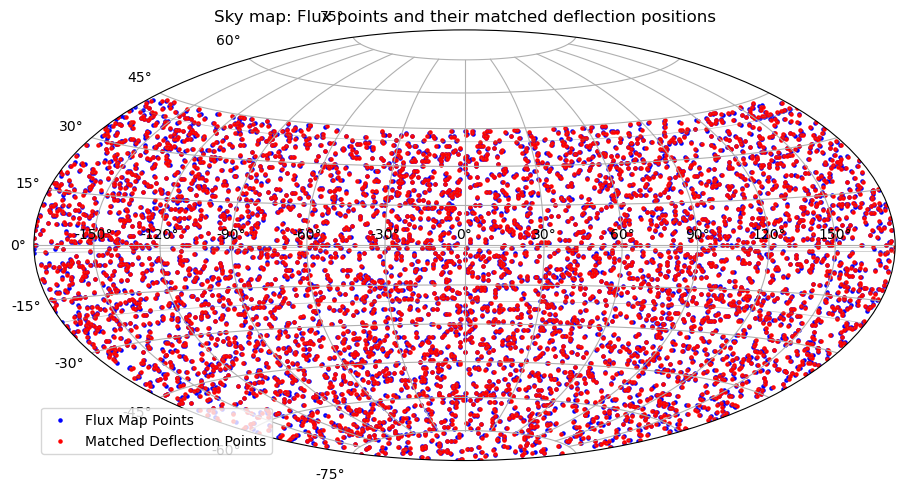

In [8]:
import matplotlib.pyplot as plt

# Limit to a random subset of points for clarity (optional)
np.random.seed(42)
N_show = 5000  # reduce if too dense
indices = np.random.choice(len(flux_map), size=N_show, replace=False)

# Prepare RA/Dec in radians for both flux and deflection (flip RA for Hammer)
ra_flux = np.radians((flux_map['RA'][indices] + 180) % 360 - 180)
dec_flux = np.radians(flux_map['dec'][indices])

ra_defl = np.radians((defl_ra[idx_match][indices] + 180) % 360 - 180)
dec_defl = np.radians(defl_dec[idx_match][indices])

# --- Plot ---
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='hammer')

# Plot flux points
ax.scatter(ra_flux, dec_flux, color='blue', s=5, label='Flux Map Points')

# Plot matched deflection points
ax.scatter(ra_defl, dec_defl, color='red', s=5, label='Matched Deflection Points')

# Draw lines connecting them (optional)
for i in range(N_show):
    ax.plot([ra_flux[i], ra_defl[i]], [dec_flux[i], dec_defl[i]], color='gray', linewidth=0.5, alpha=0.5)

ax.set_title('Sky map: Flux points and their matched deflection positions')
ax.grid(True)
ax.legend(loc='lower left')
plt.tight_layout()
plt.show()


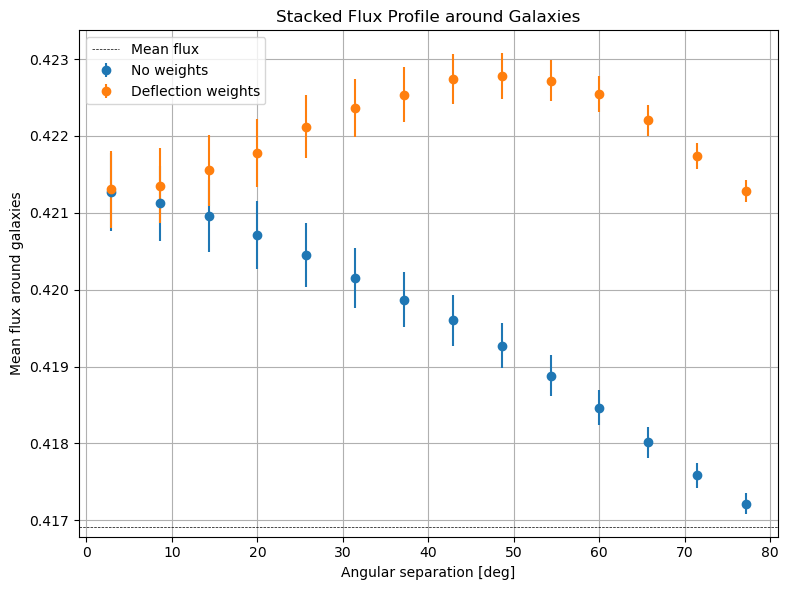

In [6]:
from scipy.spatial import cKDTree
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np

def sph_to_cart(ra_deg, dec_deg):
    ra = np.radians(ra_deg)
    dec = np.radians(dec_deg)
    x = np.cos(dec) * np.cos(ra)
    y = np.cos(dec) * np.sin(ra)
    z = np.sin(dec)
    return np.column_stack((x, y, z))

def average_flux_profile_kdtree(
    galaxy_ra, galaxy_dec,
    flux_ra, flux_dec, flux_val,
    bins_deg,
    deflection_l=None, deflection_b=None, deflection_val=None
):
    # Convert flux and galaxy positions to Cartesian
    flux_xyz = sph_to_cart(flux_ra, flux_dec)
    galaxy_xyz = sph_to_cart(galaxy_ra, galaxy_dec)

    # --- Optional deflection-based weights ---
    if deflection_l is not None and deflection_b is not None and deflection_val is not None:
        # Convert (l, b) → (RA, Dec)
        l = deflection_l * u.deg
        b = deflection_b * u.deg
        gal_coords = SkyCoord(l=l, b=b, frame='galactic')
        eq_coords = gal_coords.icrs
        defl_ra = eq_coords.ra.deg
        defl_dec = eq_coords.dec.deg

        defl_xyz = sph_to_cart(defl_ra, defl_dec)
        tree_defl = cKDTree(defl_xyz)

        # Match each flux point to nearest deflection point
        _, idx_match = tree_defl.query(flux_xyz, k=1)
        matched_deflections = deflection_val[idx_match]

        # Avoid division by zero or NaN
        matched_deflections = np.where(matched_deflections == 0, np.nan, matched_deflections)
        weights_all = 1.0 / matched_deflections
        weights_all = np.nan_to_num(weights_all, nan=0.0, posinf=0.0, neginf=0.0)
    else:
        weights_all = None

    # --- Build spatial tree for flux points ---
    tree = cKDTree(flux_xyz)

    # Angular bin edges → chord distances
    theta_rad = np.radians(bins_deg)
    chord_bins = 2 * np.sin(theta_rad / 2)
    n_bins = len(chord_bins) - 1

    profiles = []

    for xyz in galaxy_xyz:
        idx_all = tree.query_ball_point(xyz, chord_bins[-1])
        if not idx_all:
            profiles.append([np.nan] * n_bins)
            continue

        dists = np.linalg.norm(flux_xyz[idx_all] - xyz, axis=1)
        fluxes = flux_val[idx_all]
        flux_binned = np.zeros(n_bins)

        if weights_all is not None:
            weights = weights_all[idx_all]
        else:
            weights = None

        for i in range(n_bins):
            mask = (dists >= chord_bins[i]) & (dists < chord_bins[i + 1])
            if np.any(mask):
                if weights is not None:
                    flux_binned[i] = np.average(fluxes[mask], weights=weights[mask])
                else:
                    flux_binned[i] = np.mean(fluxes[mask])
            else:
                flux_binned[i] = np.nan

        profiles.append(flux_binned)

    profiles = np.array(profiles)
    mean_profile = np.nanmean(profiles, axis=0)
    std_profile = np.nanstd(profiles, axis=0) / np.sqrt(np.sum(~np.isnan(profiles), axis=0))

    return mean_profile, std_profile, (bins_deg[:-1] + bins_deg[1:]) / 2

# === Load data ===
gxs_file = '../data/2MRSxWISE_VLS_d1d5_sinAGNWISEniBPT_control_SF_passive_cz_Kabs_ang5_cz1000.txt'
agn_file = '../data/VLS_WISEorBPT_AGNs_def_control.txt' # ANGs controladas en K
defl_file = '../data/JF12_GMFdeflection_Z1_E10EeV.csv'

cz_min = 1200
cz_max = 3600
gxs_total = ascii.read(gxs_file)
gxs_total = gxs_total[gxs_total['_DEJ2000'] < 45.]
gxs_total = gxs_total[(gxs_total['cz']>cz_min) & (gxs_total['cz']<cz_max)]
gxs_total = gxs_total[(gxs_total['K_abs'] > -24.)&(gxs_total['K_abs']<-22.5)]  # Filter by K-band absolute magnitude
flux_map_total = ascii.read('../data/Auger/flux_a8_lb.dat')

# === Process different class galaxies ===
mean_flux = []
err_flux = []
for weights_type in ['no weights', 'deflection weights']:

    flux_map = flux_map_total

    galaxy_ra = gxs_total['_RAJ2000']
    galaxy_dec = gxs_total['_DEJ2000']

    flux_ra = flux_map['RA']
    flux_dec = flux_map['dec']
    flux_val = flux_map['Flux[km^-2_sr^-1_yr^-1]']

    bins = np.linspace(0, 80, 15)

    if weights_type == 'deflection weights':
        defl_map = ascii.read(defl_file)
        defl_l = defl_map['l']
        defl_b = defl_map['b']
        defl_val = defl_map['deflection'] 

        _mean_flux, _err_flux, theta_bins = average_flux_profile_kdtree(
            galaxy_ra, galaxy_dec, flux_ra, flux_dec, flux_val, bins, \
                deflection_l = defl_l, deflection_b = defl_b, deflection_val = defl_val)
        mean_flux.append(_mean_flux)
        err_flux.append(_err_flux)

    else:
        _mean_flux, _err_flux, theta_bins = average_flux_profile_kdtree(
            galaxy_ra, galaxy_dec, flux_ra, flux_dec, flux_val, bins)
        mean_flux.append(_mean_flux)
        err_flux.append(_err_flux)

    # --- Add sky map ---
    fig_sky, ax_sky = plt.subplots(subplot_kw={'projection': 'hammer'}, figsize=(10, 5))

    # RA flip for hammer
    ra_flux = np.radians((flux_ra + 180) % 360 - 180)
    dec_flux = np.radians(flux_dec)
    flux_norm = (flux_val - np.min(flux_val)) / (np.max(flux_val) - np.min(flux_val))

    # Plot flux map
    sc = ax_sky.scatter(ra_flux, dec_flux, c=flux_val, cmap='coolwarm', s=5, alpha=0.8)

    # Plot galaxies
    ra_gxs = np.radians((galaxy_ra + 180) % 360 - 180)
    dec_gxs = np.radians(galaxy_dec)
    ax_sky.scatter(ra_gxs, dec_gxs, color='black', s=8, label='Galaxies')

    # Add colorbar
    cbar = fig_sky.colorbar(sc, ax=ax_sky, orientation='horizontal', pad=0.07, shrink=0.8)
    cbar.set_label('Flux [km$^{-2}$ sr$^{-1}$ yr$^{-1}$]')

    # Add rest of layout
    ax_sky.set_title(f'Sky map: {cz_min}-{cz_max} km/s')
    ax_sky.grid(True)
    ax_sky.legend(loc='lower left')

    plt.figure(fig_sky.number)
    plt.tight_layout()
    plt.savefig('../plots/flux_vs_theta_sky_map_{}.png'.format(weights_type), dpi=300)
    plt.close(fig_sky)


# --- Final profile plot ---
fig_profile, ax_profile = plt.subplots(figsize=(8, 6))
ax_profile.errorbar(theta_bins, mean_flux[0], yerr=err_flux[0], fmt='o', label=f'No weights')
ax_profile.errorbar(theta_bins, mean_flux[1], yerr=err_flux[1], fmt='o', label=f'Deflection weights')


ax_profile.axhline(np.mean(flux_map_total['Flux[km^-2_sr^-1_yr^-1]']), color='black', linestyle='--', linewidth=0.5, label='Mean flux')
ax_profile.set_xlabel('Angular separation [deg]')
ax_profile.set_ylabel('Mean flux around galaxies')
ax_profile.set_title('Stacked Flux Profile around Galaxies')
ax_profile.grid()
ax_profile.legend()
fig_profile.tight_layout()
plt.show()

